In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
import shutil
import pandas as pd
import matplotlib.pyplot as plt

dataset_dir = "dataset"
raw_img_dir = os.path.join(dataset_dir, "raw-img")

if os.path.exists(raw_img_dir) and len(os.listdir(raw_img_dir)) > 0:
    print(f"Dataset already exists at {raw_img_dir}. Skipping download.")
else:
    print("Dataset not found. Attempting to download...")
    try:
        import kagglehub
        dataset_path = kagglehub.dataset_download("alessiocorrado99/animals10", path=dataset_dir)
        print(f"Dataset downloaded to: {dataset_path}")
    except ImportError:
        print("kagglehub not found. Please install it using 'pip install kagglehub'")
        print("Attempting manual download...")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print(f"Please ensure kagglehub is properly configured and the dataset exists.")
        print(f"You can also manually download the dataset from Kaggle to {dataset_dir}")

Dataset already exists at dataset\raw-img. Skipping download.


In [3]:
data = []
for class_name in os.listdir(f"{dataset_dir}/raw-img"):
    for filename in os.listdir(f"{dataset_dir}/raw-img/{class_name}"):
        data.append({"filename": f"{dataset_dir}/raw-img/{class_name}/{filename}", "class": class_name})

df = pd.DataFrame(data)
df.to_csv(f"{dataset_dir}/_annotations.csv", index=False)

In [4]:
# Read the annotations file
df = pd.read_csv(f"{dataset_dir}/_annotations.csv")

# Create train, test, valid directories
for split in ['train', 'test', 'valid']:
    os.makedirs(os.path.join(dataset_dir, split), exist_ok=True)

# Split the data
train_df, test_valid_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, stratify=test_valid_df['class'], random_state=42)

# Function to copy files and create new annotations
def process_split(split_df, split_name):
    new_annotations = []
    for _, row in split_df.iterrows():
        src = row['filename']
        dst = os.path.join(dataset_dir, split_name, os.path.basename(src))
        shutil.copy(src, dst)
        new_annotations.append({'filename': os.path.basename(src), 'class': row['class']})
    
    new_df = pd.DataFrame(new_annotations)
    new_df.to_csv(os.path.join(dataset_dir, f'{split_name}_annotations.csv'), index=False)

# Process each split
process_split(train_df, 'train')
process_split(valid_df, 'valid')
process_split(test_df, 'test')

print("Data split and reorganized into train, test, and valid directories.")


Data split and reorganized into train, test, and valid directories.


In [7]:
# Set up paths
dataset_dir = "dataset"
raw_img_dir = os.path.join(dataset_dir, "raw-img")
annotations_file = os.path.join(dataset_dir, "_annotations.csv")

# Create annotations file if it doesn't exist
if not os.path.exists(annotations_file):
    data = []
    for class_name in os.listdir(raw_img_dir):
        class_dir = os.path.join(raw_img_dir, class_name)
        for filename in os.listdir(class_dir):
            data.append({"filename": os.path.join(class_dir, filename), "class": class_name})
    
    df = pd.DataFrame(data)
    df.to_csv(annotations_file, index=False)

# Read the annotations file
df = pd.read_csv(annotations_file)

# Create train, test, valid directories
for split in ['train', 'test', 'valid']:
    os.makedirs(os.path.join(dataset_dir, split), exist_ok=True)

# Split the data
train_df, test_valid_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, stratify=test_valid_df['class'], random_state=42)

# Function to create new annotations
def create_split_annotations(split_df, split_name):
    split_dir = os.path.join(dataset_dir, split_name)
    split_df['filename'] = split_df['filename'].apply(lambda x: os.path.join(split_dir, os.path.basename(x)))
    split_df.to_csv(os.path.join(dataset_dir, f'{split_name}_annotations.csv'), index=False)

# Create split annotations
create_split_annotations(train_df, 'train')
create_split_annotations(valid_df, 'valid')
create_split_annotations(test_df, 'test')

batch_size = 64

# Set up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load and preprocess the data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(dataset_dir, 'train_annotations.csv')),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(os.path.join(dataset_dir, 'valid_annotations.csv')),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

print(f"Found {len(train_generator.filenames)} images belonging to {len(train_generator.class_indices)} classes in the training set.")
print(f"Found {len(validation_generator.filenames)} images belonging to {len(validation_generator.class_indices)} classes in the validation set.")

Found 18325 validated image filenames belonging to 10 classes.
Found 3927 validated image filenames belonging to 10 classes.
Found 18325 images belonging to 10 classes in the training set.
Found 3927 images belonging to 10 classes in the validation set.


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

def create_improved_model(input_shape, num_classes):
    # Create base model with pre-trained ResNet50V2
    base_model = applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Create the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = len(train_generator.class_indices)

# Create and compile the model
model = create_improved_model(input_shape, num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Create checkpoint callback
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, 'model_checkpoint.h5')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Function to load the latest checkpoint
def load_latest_checkpoint(model, checkpoint_path):
    if os.path.exists(checkpoint_path):
        print(f"Loading weights from checkpoint: {checkpoint_path}")
        model.load_weights(checkpoint_path)
        return True
    return False

# Load checkpoint if it exists
load_latest_checkpoint(model, checkpoint_path)

# Phase 1: Train only the top layers
print("Phase 1: Training top layers...")
history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint_callback]
)

# Phase 2: Fine-tune the last few layers of ResNet
print("\nPhase 2: Fine-tuning ResNet layers...")
base_model = model.layers[0]
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all but the last 30 layers
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=30,
    callbacks=[early_stop, reduce_lr, checkpoint_callback]
)


94668760/94668760 [==============================] - 6s 0us/step
Phase 1: Training top layers...
Epoch 1/20
286/286 [==============================] - ETA: 0s - loss: 0.9326 - accuracy: 0.7121
Epoch 1: val_accuracy improved from -inf to 0.91547, saving model to checkpoints\model_checkpoint.h5
286/286 [==============================] - 336s 1s/step - loss: 0.9326 - accuracy: 0.7121 - val_loss: 0.2960 - val_accuracy: 0.9155 - lr: 1.0000e-04
Epoch 2/20
286/286 [==============================] - ETA: 0s - loss: 0.4437 - accuracy: 0.8653
Epoch 2: val_accuracy improved from 0.91547 to 0.92572, saving model to checkpoints\model_checkpoint.h5
286/286 [==============================] - 297s 1s/step - loss: 0.4437 - accuracy: 0.8653 - val_loss: 0.2472 - val_accuracy: 0.9257 - lr: 1.0000e-04
Epoch 3/20
286/286 [==============================] - ETA: 0s - loss: 0.3781 - accuracy: 0.8842
Epoch 3: val_accuracy did not improve from 0.92572
286/286 [==============================] - 297s 1s/step - los

KeyboardInterrupt: 

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc:.4f}')

# Save the model
model.save('animal_classification_model.tf')
print("Model saved as animal_classification_model.tf")

In [19]:
# Load the weights file to inspect its structure
import h5py

with h5py.File('checkpoints/model_checkpoint.h5', 'r') as f:
    # Print the keys to see the layer names and shapes
    def print_structure(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"{name}: {obj.shape}")
    
    print("Weight file structure:")
    f.visititems(print_structure)

Weight file structure:
batch_normalization/batch_normalization/beta:0: (2048,)
batch_normalization/batch_normalization/gamma:0: (2048,)
batch_normalization/batch_normalization/moving_mean:0: (2048,)
batch_normalization/batch_normalization/moving_variance:0: (2048,)
dense_4/dense_4/bias:0: (512,)
dense_4/dense_4/kernel:0: (2048, 512)
dense_5/dense_5/bias:0: (256,)
dense_5/dense_5/kernel:0: (512, 256)
dense_6/dense_6/bias:0: (10,)
dense_6/dense_6/kernel:0: (256, 10)
resnet50v2/conv1_conv/bias:0: (64,)
resnet50v2/conv1_conv/kernel:0: (7, 7, 3, 64)
resnet50v2/conv2_block1_0_conv/bias:0: (256,)
resnet50v2/conv2_block1_0_conv/kernel:0: (1, 1, 64, 256)
resnet50v2/conv2_block1_1_bn/beta:0: (64,)
resnet50v2/conv2_block1_1_bn/gamma:0: (64,)
resnet50v2/conv2_block1_1_bn/moving_mean:0: (64,)
resnet50v2/conv2_block1_1_bn/moving_variance:0: (64,)
resnet50v2/conv2_block1_1_conv/kernel:0: (1, 1, 64, 64)
resnet50v2/conv2_block1_2_bn/beta:0: (64,)
resnet50v2/conv2_block1_2_bn/gamma:0: (64,)
resnet50v2/c

Model Summary:
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_49 (Dropout)        (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 25

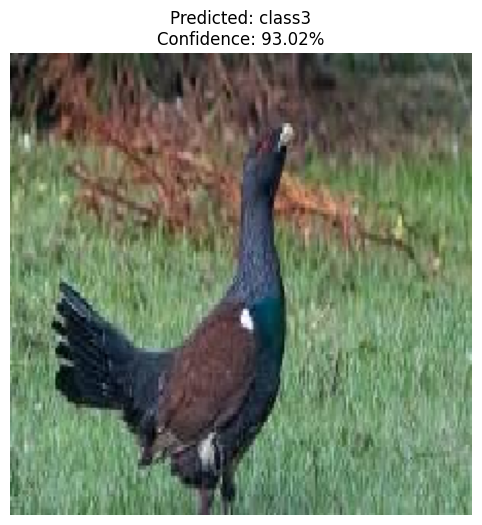


Top 3 Predictions:
class3: 93.02%
Cat: 6.97%
Squirrel: 0.00%


In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import random

# First recreate the model architecture
base_model = applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Create the model with exact layer names
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(name='global_average_pooling2d'),
    layers.BatchNormalization(name='batch_normalization'),
    layers.Dense(512, activation='relu', name='dense_4'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', name='dense_5'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax', name='dense_6')
])

# Build the model with a sample input
dummy_input = tf.random.normal((1, 224, 224, 3))
_ = model(dummy_input)

# Print model summary to see layer names and shapes
print("Model Summary:")
model.summary()

# Load weights layer by layer
with h5py.File('checkpoints/model_checkpoint.h5', 'r') as f:
    # Load weights for each layer
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):  # Skip the base model since it uses pretrained weights
            continue
        if hasattr(layer, 'weights') and len(layer.weights) > 0:
            print(f"\nLoading weights for layer: {layer.name}")
            for weight in layer.weights:
                weight_name = weight.name.replace(layer.name + '/', '')
                weight_path = f"{layer.name}/{layer.name}/{weight_name}"
                if weight_path in f:
                    print(f"Loading {weight_path}")
                    weight_value = f[weight_path][:]
                    print(f"Weight shape in file: {weight_value.shape}")
                    print(f"Layer weight shape: {weight.shape}")
                    if weight_value.shape == weight.shape:
                        weight.assign(weight_value)
                    else:
                        print(f"Shape mismatch for {weight_path}")

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Function to preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array, img

# Function to predict and display results
def predict_and_display(image_path, class_names):
    img_array, original_img = preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100
    
    plt.figure(figsize=(8, 6))
    plt.imshow(original_img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}%')
    plt.show()
    
    top_3_idx = np.argsort(predictions[0])[-3:][::-1]
    print("\nTop 3 Predictions:")
    for idx in top_3_idx:
        print(f"{class_names[idx]}: {predictions[0][idx]*100:.2f}%")

# Define your class names
class_names = ['Butterfly', 'Cat', 'Chicken', 'Cow', 'Dog', 
               'Elephant', 'Horse', 'Spider', 'Goat', 'Squirrel']  # Replace with your actual class names

# Get a random image from the test folder
test_folder = "dataset/test"
test_images = [f for f in os.listdir(test_folder) if f.endswith('.jpeg')]
random_image = random.choice(test_images)
test_image_path = os.path.join(test_folder, random_image)

# Run prediction on the random image
predict_and_display(test_image_path, class_names)